In [4]:
import os
from rnnmorph.data_preparation.grammeme_vectorizer import GrammemeVectorizer

from src.absa_parser import Dataset

def semeval_get_data(filename):
    data = Dataset(filename, "ru", "gram_output.json")
    print("Num of reviews: " + str(len(data.reviews)))
    print("Num of opinions: " + str(data.get_opinion_count()))
    print(data.tokenized_reviews[0][0])
    print(data.pos_tagged_reviews[0][0])
    return data

TRAIN_FILENAME = "/Volumes/My Passport/Datasets/Sentiment/ABSA16/ABSA16_Restaurants_Ru_Train.xml"
TEST_FILENAME = "/Volumes/My Passport/Datasets/Sentiment/ABSA16/ABSA16_Restaurants_Ru_Test.xml"
PICKLED_TRAIN_FILENAME = "train.json"
PICKLED_TEST_FILENAME = "test.json"
GRAMMEME_VECTORIZER_FILENAME = "gram_output.json"

if not os.path.exists(PICKLED_TRAIN_FILENAME) or not os.path.exists(PICKLED_TEST_FILENAME):
    print("Loading from xml...")
    train_data = semeval_get_data(TRAIN_FILENAME)
    test_data = semeval_get_data(TEST_FILENAME)
    train_data.save(PICKLED_TRAIN_FILENAME)
    test_data.save(PICKLED_TEST_FILENAME)
else:
    print("Loading from json...")
    train_data = semeval_get_data(PICKLED_TRAIN_FILENAME)
    test_data = semeval_get_data(PICKLED_TEST_FILENAME)

grammeme_vectorizer = GrammemeVectorizer(GRAMMEME_VECTORIZER_FILENAME)
vocabulary = train_data.get_vocabulary()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loading from json...
Num of reviews: 312
Num of opinions: 4089
[<Word "Добрый" from 0 to 6 with opinion None at 0x127e0c940>, <Word "час" from 7 to 10 with opinion None at 0x127e0cac8>, <Word "суток" from 11 to 16 with opinion None at 0x127e0cb00>, <Word "." from 16 to 17 with opinion None at 0x127e0cb38>]
[<PosTaggedWord "Добрый", ADJ#Case=Acc|Degree=Pos|Gender=Masc|Number=Sing, [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1] at 0x1266b45f8>, <PosTaggedWord "час", NOUN#Case=Nom|Gender=Masc|Number=Sing, [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1] at 0x1266b4668>, <PosTaggedWord "суток", NOUN#Case=Gen|Number=Plur, [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1] 

In [ ]:
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score

def form_text_vectorizer(reviews):
    vectorizer = TfidfVectorizer(ngram_range=(1, 1))
    all_texts = []
    for review in reviews:
        for sentence in review:
            words = [word.text for word in sentence]
            text = " ".join(words)
            all_texts.append(text)
    vectorizer.fit(all_texts)
    return vectorizer

def form_context_samples(reviews, pos_vector_size, context_window):
    text_vectorizer = form_text_vectorizer(reviews)
    all_texts = []
    all_pos_vectors = []
    target = []
    for review in reviews:
        for sentence in review:
            for i, word in enumerate(sentence):
                left_padding = context_window - i
                right_padding = i + 1 + context_window - len(sentence)
                
                begin = i - context_window if left_padding <= 0 else 0
                end = i + 1 + context_window if right_padding <= 0 else len(sentence)
                text = " ".join([word.text for word in sentence[begin:end]])
                if text != '':
                    target.append(int(word.is_colored()))
                    all_texts.append(text)

                psos = [word.vector for word in sentence[begin:end]]
                vectorized_pos = [elem for vector in psos for elem in vector]
                if left_padding > 0:
                    vectorized_pos = [0 for _ in range(left_padding * pos_vector_size)] + vectorized_pos
                if right_padding > 0:
                    vectorized_pos = vectorized_pos + [0 for _ in range(right_padding * pos_vector_size)]
                all_pos_vectors.append(vectorized_pos)
            
    all_pos_vectors = csr_matrix(all_pos_vectors)
    vectorized_texts = text_vectorizer.transform(all_texts)
    
    return hstack([vectorized_texts, all_pos_vectors]), target

X, y = form_context_samples(train_data.pos_tagged_reviews, 
                            grammeme_vectorizer.grammemes_count(), 1)
print(X.shape)
print(sum(y))

pipe = Pipeline([('clf', LinearSVC())])
param_grid = [{'clf__C': [1, 10, 100, 1000]}]
grid = GridSearchCV(pipe, scoring=make_scorer(roc_auc_score), cv=5, param_grid=param_grid)
grid.fit(X, y)
print(grid.cv_results_['mean_test_score'])

In [3]:
from src.embeddings import shrink_w2v
shrink_w2v("/Volumes/My Passport/Models/russian-big-w2v.txt", vocabulary, 6700, "w2v.txt")

Parsed words: 0, intersection: 0, unknown words:8578
Parsed words: 100000, intersection: 5628, unknown words:2950
Parsed words: 200000, intersection: 6219, unknown words:2359
Parsed words: 300000, intersection: 6449, unknown words:2129
Parsed words: 400000, intersection: 6543, unknown words:2035
Parsed words: 500000, intersection: 6615, unknown words:1963
Parsed words: 600000, intersection: 6651, unknown words:1927
Parsed words: 700000, intersection: 6681, unknown words:1897


In [18]:
from src.train import train_model

model = train_model(train_data.pos_tagged_reviews, 
                    vocabulary, 
                    grammeme_vectorizer.grammemes_count(), 
                    epochs=9, 
                    rnn_size=32, 
                    gram_hidden_size=16,
                    n_layers=2,
                    val_size=0.2)

Unknown words in w2v.txt: 1878
Train loss: 550.6564365625381, val loss: 589.6675605773926, val roc_auc: 0.7227952451592058
Train loss: 472.3238750696182, val loss: 506.7734603881836, val roc_auc: 0.8778208214399835
Train loss: 410.6841461658478, val loss: 450.0780601501465, val roc_auc: 0.9413540701587149
Train loss: 382.127826154232, val loss: 435.3472709655762, val roc_auc: 0.9518035941569511
Train loss: 373.9046055674553, val loss: 430.38434982299805, val roc_auc: 0.9552744217555924
Train loss: 369.2339761853218, val loss: 427.72251892089844, val roc_auc: 0.9570651184336659
Train loss: 366.8809938430786, val loss: 426.4794120788574, val roc_auc: 0.9576378066609899
Train loss: 364.18328112363815, val loss: 425.51363372802734, val roc_auc: 0.9585317045915024
Train loss: 362.4456470608711, val loss: 425.20157623291016, val roc_auc: 0.9587025180877099


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
No handles with labels found to put in legend.


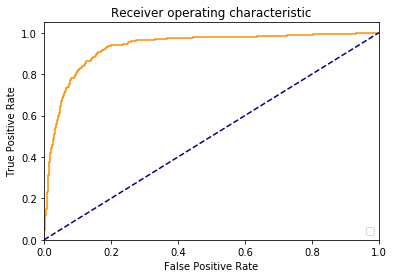

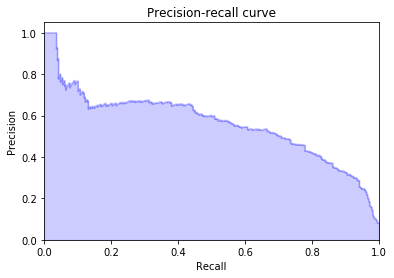

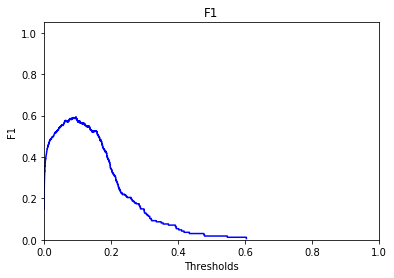

Test loss: 850.6273193359375, roc auc: 0.9306395956159387, threshold: 0.09562665969133377, f1: 0.5917808219178082, f-macro: 0.5301545129786132


In [19]:
%matplotlib inline
import torch
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score

from src.model import load_model
from src.train import get_batches, do_epoch
from src.metrics import plot_roc_auc, plot_precision_recall, plot_f1, choose_threshold_by_f1

def test_model(model, test_data, vocabulary, gram_vector_size, batch_size=128, max_length=40):
    use_cuda = torch.cuda.is_available()
    criterion = torch.nn.BCELoss(size_average=False)
    test_loss = 0
    test_count = 0
    all_y = []
    all_pred = []
    f1s = []
    test_batches = get_batches(test_data, vocabulary, gram_vector_size, batch_size, max_length)
    for text_batch, gram_batch, y in test_batches:
        model.eval()
        loss, predictions = do_epoch(model, criterion, text_batch, gram_batch, y, use_cuda)
        test_loss += loss
        test_count += 1

        lengths = []
        for i in range(text_batch.size(0)):
            lengths.append(sum([int(elem != 0) for elem in text_batch[i].data]))
        for i in range(y.size(0)):
            review_y = list(y.data[i])[:lengths[i]]
            review_pred = list(predictions.data[i])[:lengths[i]]
            f1s.append(f1_score(review_y, [int(e > 0.0894) for e in review_pred]))
            all_y += review_y
            all_pred += review_pred
    plot_roc_auc(all_y, all_pred)
    plot_precision_recall(all_y, all_pred)
    plot_f1(all_y, all_pred)
    threshold = choose_threshold_by_f1(all_y, all_pred)
    all_pred_round = [int(e > threshold) for e in all_pred]
    print("Test loss: {test_loss}, roc auc: {roc_auc}, threshold: {threshold}, f1: {f1}, f-macro: {f_macro}".format(
        test_loss = test_loss/test_count,
        roc_auc = roc_auc_score(all_y, all_pred),
        f1 = f1_score(all_y, all_pred_round),
        f_macro = sum(f1s)/len(f1s),
        threshold = threshold
    ))

model, _ = load_model("model.pt", torch.cuda.is_available())
test_model(model, test_data.pos_tagged_reviews, vocabulary, grammeme_vectorizer.grammemes_count())